<a href="https://colab.research.google.com/github/adeviney/customer-retention-model/blob/main/ModelDevelopment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Development
- Alexis Deviney
-04/01/2022

To-Do:
1. Preprocessing
2. Try different models: Supervised - KNN, Logistic Regression, Decision Tree, Random Forest, Bagging, Gradient Boosting
3. Evaluate model performance: Accuracy, precision, recall, (classification report), confusion matrix, ROC Curves
4. Choose production model 

## Imports

In [66]:
# Imports
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#preprocessing tools and tuning
from sklearn.preprocessing import StandardScaler, OneHotEncoder,  LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

#SMOTE
from imblearn.over_sampling import SMOTE, SMOTENC

#models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#evaluation metrics
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay

# prettier display
import seaborn as sns
from sklearn import set_config
set_config(display='diagram')

In [67]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
df = pd.read_csv('/content/drive/MyDrive/Coding Dojo Bootcamp/Project 2/cleaned_customer_data.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalCharges_Diff,Internet,NumServices
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,-3.814697e-07,Yes,2
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,No,One year,No,Mailed check,56.95,1889.50,0,4.680000e+01,Yes,4
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,-4.500015e-01,Yes,4
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,...,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,6.275000e+01,Yes,4
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,-1.024999e+01,Yes,2


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customerID         7043 non-null   object 
 1   gender             7043 non-null   object 
 2   SeniorCitizen      7043 non-null   object 
 3   Partner            7043 non-null   object 
 4   Dependents         7043 non-null   object 
 5   tenure             7043 non-null   int64  
 6   PhoneService       7043 non-null   object 
 7   MultipleLines      7043 non-null   object 
 8   InternetService    7043 non-null   object 
 9   OnlineSecurity     7043 non-null   object 
 10  OnlineBackup       7043 non-null   object 
 11  DeviceProtection   7043 non-null   object 
 12  TechSupport        7043 non-null   object 
 13  StreamingTV        7043 non-null   object 
 14  StreamingMovies    7043 non-null   object 
 15  Contract           7043 non-null   object 
 16  PaperlessBilling   7043 

In [70]:
df[['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Internet']]\
 = df[['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Internet']].replace({'No': 0, 'Yes': 1})

## Pre-processing Steps

In [71]:
# Train-test split
X = df.drop(columns = ['customerID', 'Churn'])
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# Selectors
cat_selector = make_column_selector(dtype_include = 'object')
num_selector = make_column_selector(dtype_include = 'number')

# Preprocessing Classes
encoder = OneHotEncoder(sparse=False, handle_unknown = 'ignore')
scaler = StandardScaler()


#Imputers
freq_imputer = SimpleImputer(strategy='most_frequent')
median_imputer = SimpleImputer(strategy='median') 

#Pipelines
cat_processor = make_pipeline(freq_imputer, encoder, scaler)
num_processor = make_pipeline(median_imputer, scaler)

#Tuples
cat_tuple = (cat_processor, cat_selector)
num_tuple = (num_processor, num_selector)

# Column Transformer
col_transformer = make_column_transformer(cat_tuple, num_tuple, remainder='passthrough')

#Prep for SMOTE
X_train_transformed = col_transformer.fit_transform(X_train)
X_test_transformed = col_transformer.fit_transform(X_test)
smote = SMOTE(sampling_strategy = 'auto')
X_train_smote, y_train_smote = smote.fit_resample(X_train_transformed, y_train)

# DataFrame to track model performance
modelperformance = pd.DataFrame(columns = ['model name', 'accuracy', 'roc_auc', 'precision_min', 'recall_min', 'f1-score_min', 'precision_maj', 'recall_maj', 'f1-score_maj'])

## Function to Evaluate Models

In [72]:
def evaluate_classification(model, model_name, X_train, y_train, X_test, y_test, cmap='Greens',
                            normalize='true', classes=None, figsize=(20,10), df_performance = modelperformance):
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    print(f'{model_name} Performance on the Training Set')
    print(f'Train accuracy score: {train_score}')
    train_preds = model.predict(X_train)
    print(classification_report(y_train, train_preds, target_names= classes))

    fig, ax = plt.subplots(ncols=3, nrows = 2, figsize=figsize)
    ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, cmap=cmap,
                                            display_labels=classes,
                                            ax=ax[0, 0])
    
    
    ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, cmap=cmap,
                                            display_labels=classes, normalize='true',
                                            ax=ax[0, 1])
    
    RocCurveDisplay.from_estimator(model, X_train, y_train, ax = ax[0, 2])

    print(f'{model_name} Performance on the Testing Set')
    print(f'Test accuracy score: {test_score}')
    test_preds = model.predict(X_test)
    print(classification_report(y_test, test_preds, target_names= classes))

    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap=cmap,
                                            display_labels=classes,
                                            ax=ax[1, 0])
    
    
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap=cmap,
                                            display_labels=classes, normalize='true',
                                            ax=ax[1, 1])
    
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax = ax[1, 2])
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    #record findings
    clf_rep = precision_recall_fscore_support(y_test, test_preds)
    metrics = {'model name': model_name, 'accuracy': test_score, 'roc_auc': roc_auc, \
               'precision_min': clf_rep[0][1], 'recall_min': clf_rep[1][1], 'f1-score_min': clf_rep[2][1], \
               'precision_maj': clf_rep[0][0], 'recall_maj': clf_rep[1][0], 'f1-score_maj': clf_rep[2][0]}
    df_performance = df_performance.append(metrics, ignore_index = True)
    return df_performance

## KNN Model

In [73]:
knn = KNeighborsClassifier()
knn_pipe = make_pipeline(col_transformer, knn)
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcb85db1510>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcb838206d0>)])),
                ('kneighborsclassifier', KNeighborsClassifier())])

KNN Performance on the Training Set
Train accuracy score: 0.8322605073835668
              precision    recall  f1-score   support

    No Churn       0.88      0.90      0.89      3892
       Churn       0.69      0.65      0.67      1390

    accuracy                           0.83      5282
   macro avg       0.79      0.77      0.78      5282
weighted avg       0.83      0.83      0.83      5282

KNN Performance on the Testing Set
Test accuracy score: 0.7632027257240205
              precision    recall  f1-score   support

    No Churn       0.83      0.85      0.84      1282
       Churn       0.57      0.54      0.55       479

    accuracy                           0.76      1761
   macro avg       0.70      0.69      0.70      1761
weighted avg       0.76      0.76      0.76      1761



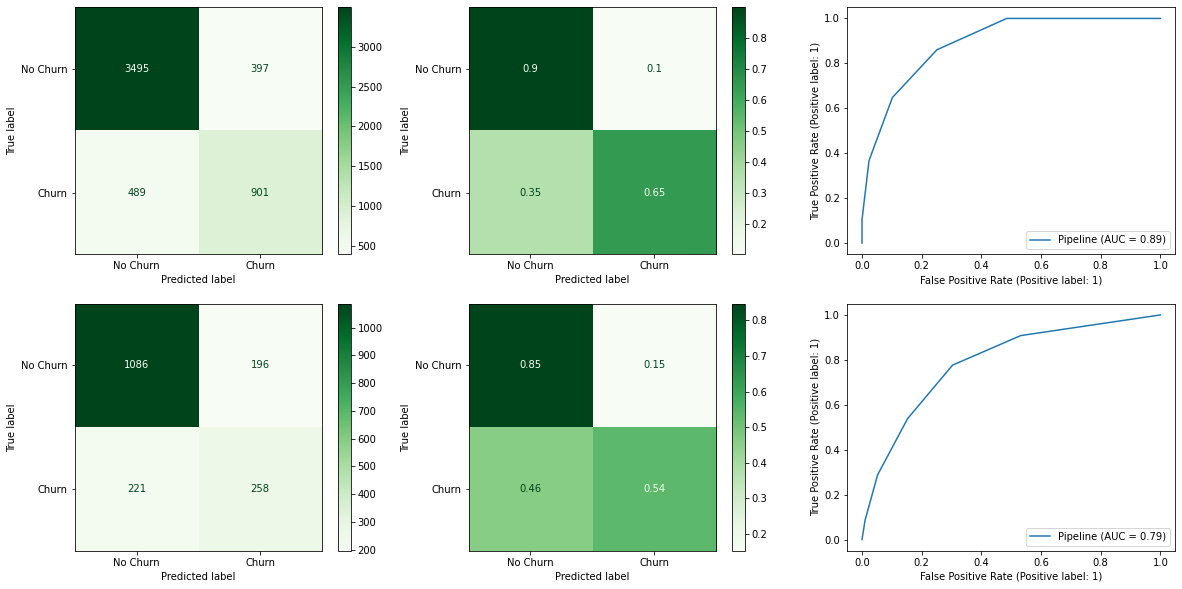

In [74]:
tempdf = evaluate_classification(knn_pipe, 'KNN', X_train, y_train, X_test, y_test, classes = ['No Churn', 'Churn'])
modelperformance = modelperformance.append(tempdf, ignore_index = True)

> Note: A class_weight parameter for this class does not exist.

### SMOTE

KNN Smote Performance on the Training Set
Train accuracy score: 0.8547019527235354
              precision    recall  f1-score   support

    No Churn       0.96      0.74      0.84      3892
       Churn       0.79      0.97      0.87      3892

    accuracy                           0.85      7784
   macro avg       0.87      0.85      0.85      7784
weighted avg       0.87      0.85      0.85      7784

KNN Smote Performance on the Testing Set
Test accuracy score: 0.6944917660420216
              precision    recall  f1-score   support

    No Churn       0.88      0.68      0.76      1282
       Churn       0.46      0.74      0.57       479

    accuracy                           0.69      1761
   macro avg       0.67      0.71      0.67      1761
weighted avg       0.76      0.69      0.71      1761



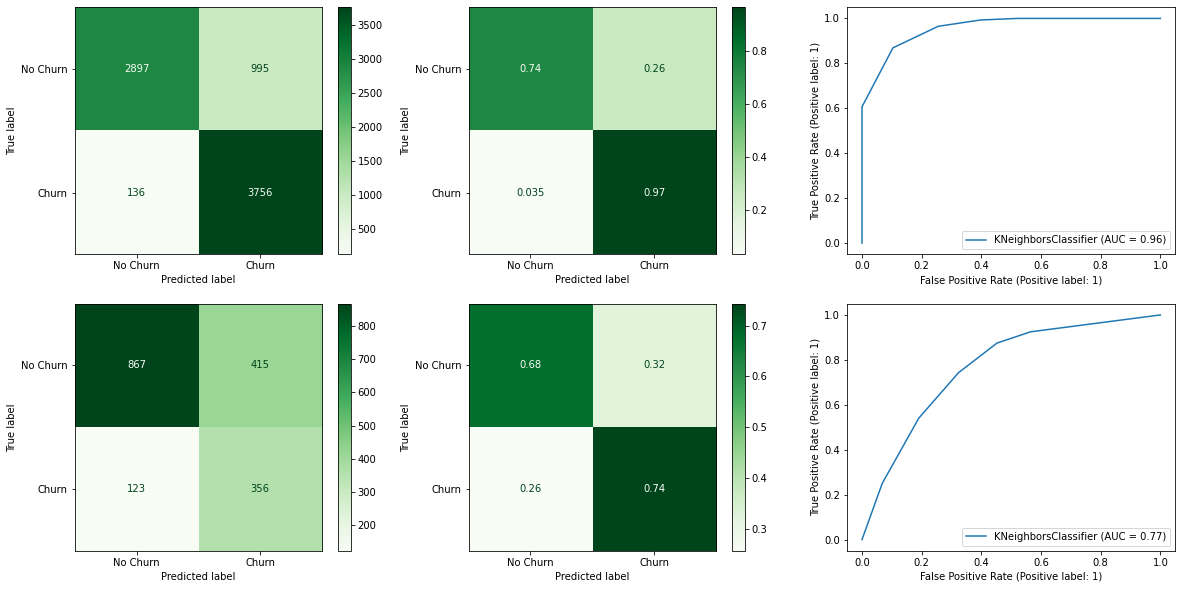

In [75]:
knn_smote = KNeighborsClassifier()
knn_smote.fit(X_train_smote, y_train_smote) 
tempdf = evaluate_classification(knn_smote, 'KNN Smote', X_train_smote, y_train_smote, X_test_transformed, y_test, classes = ['No Churn', 'Churn'])
modelperformance = modelperformance.append(tempdf, ignore_index = True)

> Much better performance on minority class.

## Logistic Regression

LogReg Performance on the Training Set
Train accuracy score: 0.8032942067398713
              precision    recall  f1-score   support

    No Churn       0.84      0.90      0.87      3892
       Churn       0.65      0.54      0.59      1390

    accuracy                           0.80      5282
   macro avg       0.75      0.72      0.73      5282
weighted avg       0.79      0.80      0.80      5282

LogReg Performance on the Testing Set
Test accuracy score: 0.8126064735945485
              precision    recall  f1-score   support

    No Churn       0.85      0.90      0.87      1282
       Churn       0.68      0.58      0.63       479

    accuracy                           0.81      1761
   macro avg       0.77      0.74      0.75      1761
weighted avg       0.81      0.81      0.81      1761



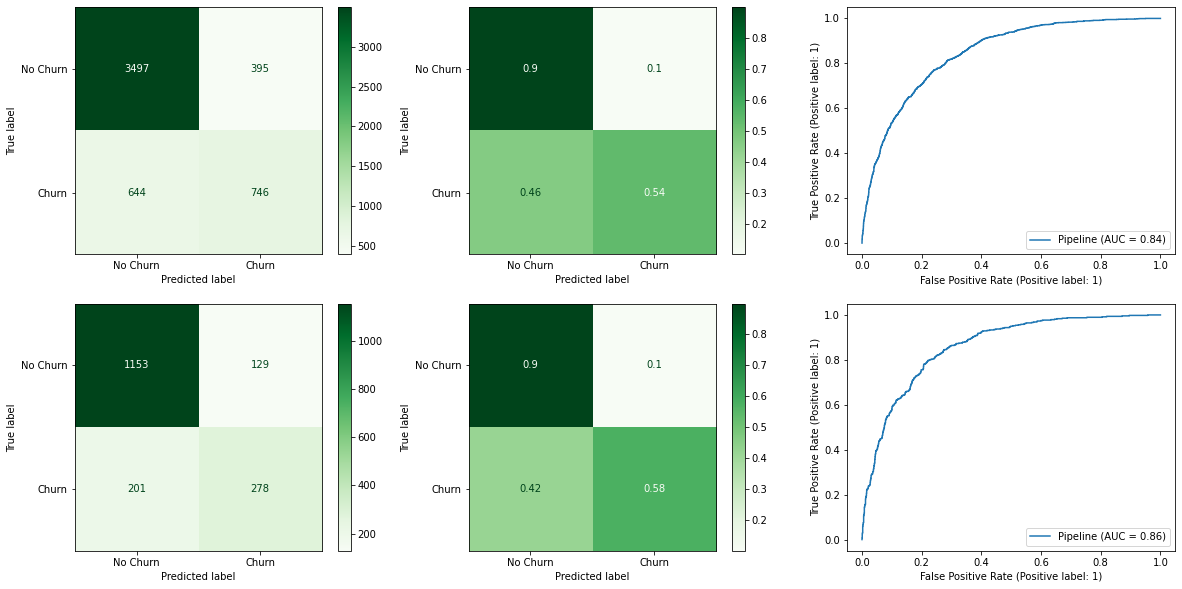

In [76]:
logreg = LogisticRegression()
logreg_pipe = make_pipeline(col_transformer, logreg)
logreg_pipe.fit(X_train, y_train)
tempdf = evaluate_classification(logreg_pipe, 'LogReg', X_train, y_train, X_test, y_test, classes = ['No Churn', 'Churn'])
modelperformance = modelperformance.append(tempdf, ignore_index = True)

### Class_Weight = Balanced

LogReg Class Balanced Performance on the Training Set
Train accuracy score: 0.7387353275274517
              precision    recall  f1-score   support

    No Churn       0.91      0.72      0.80      3892
       Churn       0.50      0.80      0.62      1390

    accuracy                           0.74      5282
   macro avg       0.71      0.76      0.71      5282
weighted avg       0.80      0.74      0.75      5282

LogReg Class Balanced Performance on the Testing Set
Test accuracy score: 0.7552526973310619
              precision    recall  f1-score   support

    No Churn       0.92      0.73      0.81      1282
       Churn       0.53      0.83      0.65       479

    accuracy                           0.76      1761
   macro avg       0.73      0.78      0.73      1761
weighted avg       0.82      0.76      0.77      1761



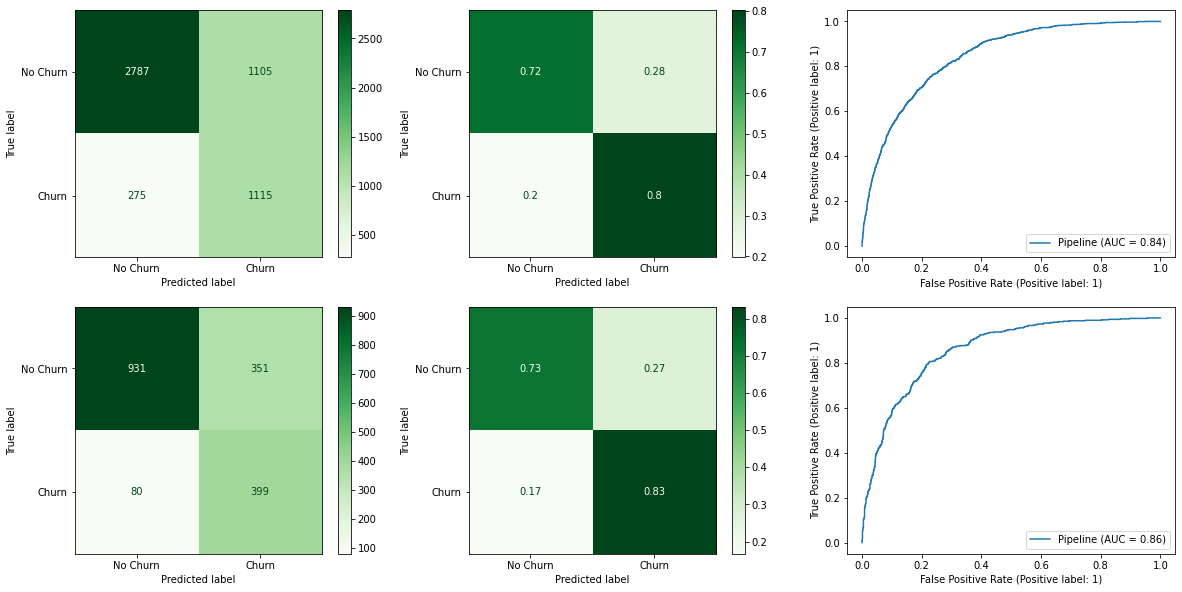

In [77]:
logreg_balanced = LogisticRegression(class_weight='balanced')
logreg_balanced_pipe = make_pipeline(col_transformer, logreg_balanced)
logreg_balanced_pipe.fit(X_train, y_train)
tempdf = evaluate_classification(logreg_balanced_pipe, 'LogReg Class Balanced', X_train, y_train, X_test, y_test, classes = ['No Churn', 'Churn'])
modelperformance = modelperformance.append(tempdf, ignore_index = True)

> Much better prediction of the 'Churn' Class!

### SMOTE

LogReg Smote Performance on the Training Set
Train accuracy score: 0.7724820143884892
              precision    recall  f1-score   support

    No Churn       0.80      0.73      0.76      3892
       Churn       0.75      0.82      0.78      3892

    accuracy                           0.77      7784
   macro avg       0.77      0.77      0.77      7784
weighted avg       0.77      0.77      0.77      7784

LogReg Smote Performance on the Testing Set
Test accuracy score: 0.7569562748438388
              precision    recall  f1-score   support

    No Churn       0.92      0.73      0.81      1282
       Churn       0.53      0.82      0.65       479

    accuracy                           0.76      1761
   macro avg       0.73      0.78      0.73      1761
weighted avg       0.81      0.76      0.77      1761



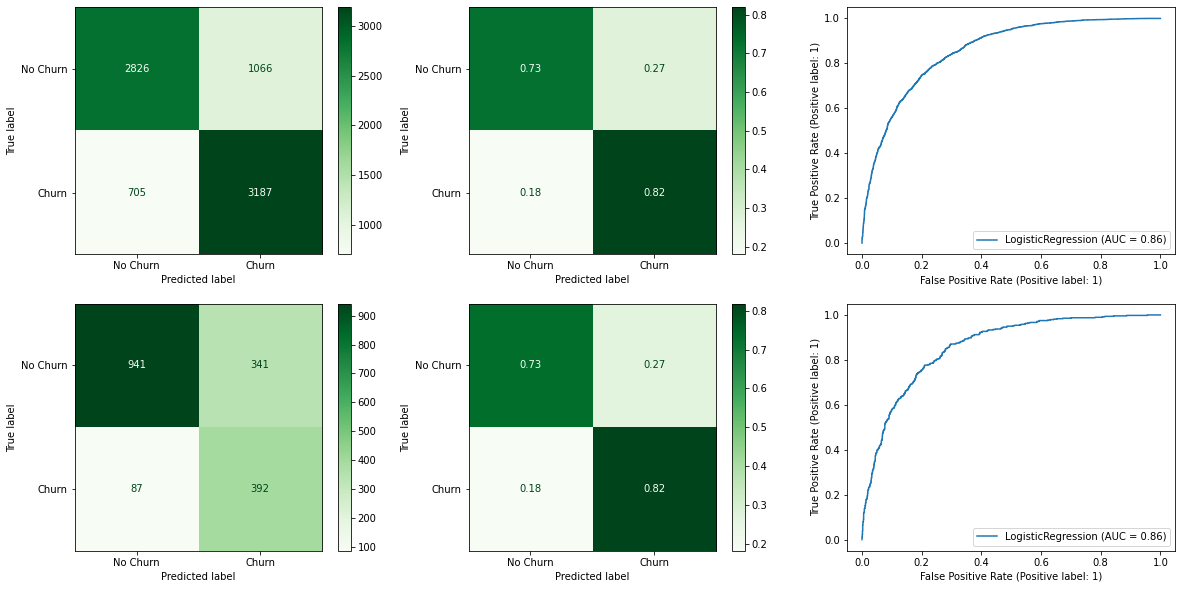

In [78]:
logreg_smote = LogisticRegression()
logreg_smote.fit(X_train_smote, y_train_smote) 
tempdf = evaluate_classification(logreg_smote, 'LogReg Smote', X_train_smote, y_train_smote, X_test_transformed, y_test, classes = ['No Churn', 'Churn'])
modelperformance = modelperformance.append(tempdf, ignore_index = True)

## Decision Tree

DecTree Performance on the Training Set
Train accuracy score: 0.998485422188565
              precision    recall  f1-score   support

    No Churn       1.00      1.00      1.00      3892
       Churn       1.00      1.00      1.00      1390

    accuracy                           1.00      5282
   macro avg       1.00      1.00      1.00      5282
weighted avg       1.00      1.00      1.00      5282

DecTree Performance on the Testing Set
Test accuracy score: 0.7433276547416241
              precision    recall  f1-score   support

    No Churn       0.81      0.84      0.83      1282
       Churn       0.53      0.49      0.51       479

    accuracy                           0.74      1761
   macro avg       0.67      0.66      0.67      1761
weighted avg       0.74      0.74      0.74      1761



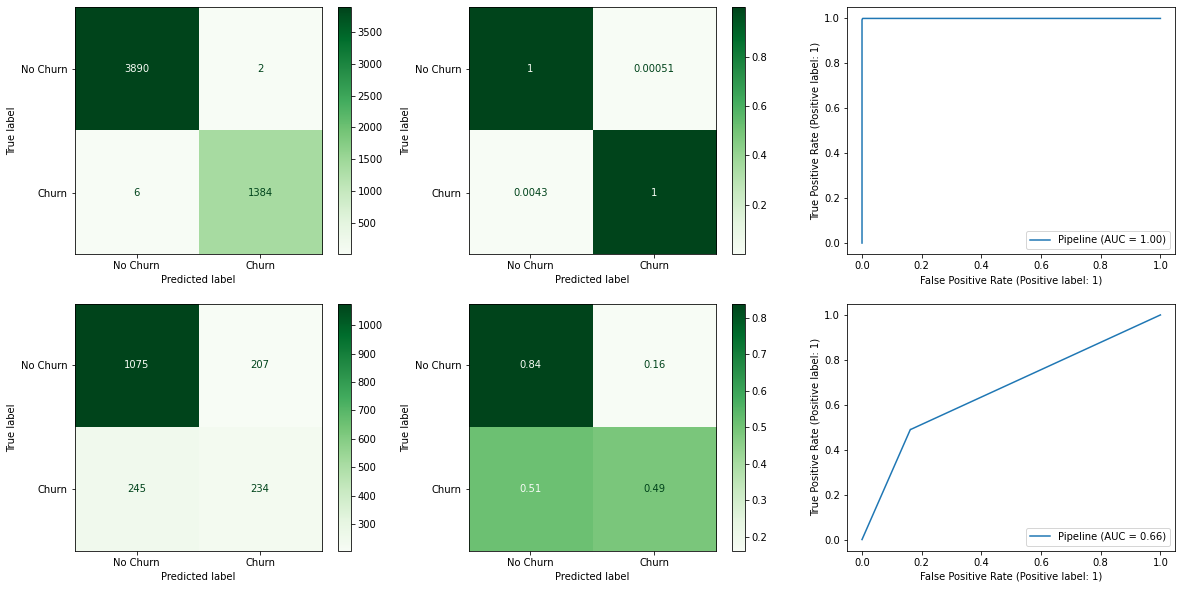

In [79]:
dectree = DecisionTreeClassifier(random_state = 42)
dectree_pipe = make_pipeline(col_transformer, dectree)
dectree_pipe.fit(X_train, y_train)
tempdf = evaluate_classification(dectree_pipe, 'DecTree', X_train, y_train, X_test, y_test, classes = ['No Churn', 'Churn'])
modelperformance = modelperformance.append(tempdf, ignore_index = True)

> Significant overfitting.

### Class_Weight = Balanced

DecTree Class Balanced Performance on the Training Set
Train accuracy score: 0.9982960999621355
              precision    recall  f1-score   support

    No Churn       1.00      1.00      1.00      3892
       Churn       0.99      1.00      1.00      1390

    accuracy                           1.00      5282
   macro avg       1.00      1.00      1.00      5282
weighted avg       1.00      1.00      1.00      5282

DecTree Class Balanced Performance on the Testing Set
Test accuracy score: 0.740488358886996
              precision    recall  f1-score   support

    No Churn       0.82      0.83      0.82      1282
       Churn       0.52      0.49      0.51       479

    accuracy                           0.74      1761
   macro avg       0.67      0.66      0.67      1761
weighted avg       0.74      0.74      0.74      1761



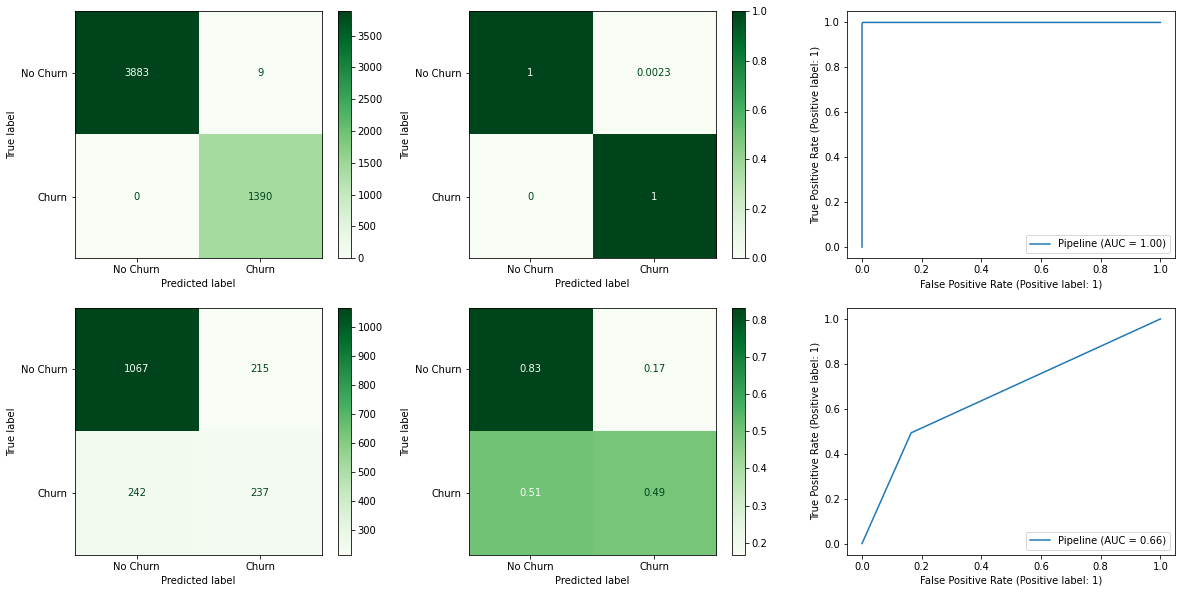

In [80]:
dectree = DecisionTreeClassifier(random_state = 42, class_weight = 'balanced')
dectree_pipe = make_pipeline(col_transformer, dectree)
dectree_pipe.fit(X_train, y_train)
tempdf = evaluate_classification(dectree_pipe, 'DecTree Class Balanced', X_train, y_train, X_test, y_test, classes = ['No Churn', 'Churn'])
modelperformance = modelperformance.append(tempdf, ignore_index = True)

> Hardly any benefit in predictions for minority class.

### SMOTE

DecTree Smote Performance on the Training Set
Train accuracy score: 0.998972250770812
              precision    recall  f1-score   support

    No Churn       1.00      1.00      1.00      3892
       Churn       1.00      1.00      1.00      3892

    accuracy                           1.00      7784
   macro avg       1.00      1.00      1.00      7784
weighted avg       1.00      1.00      1.00      7784

DecTree Smote Performance on the Testing Set
Test accuracy score: 0.5139125496876774
              precision    recall  f1-score   support

    No Churn       0.82      0.42      0.56      1282
       Churn       0.33      0.75      0.46       479

    accuracy                           0.51      1761
   macro avg       0.58      0.59      0.51      1761
weighted avg       0.69      0.51      0.53      1761



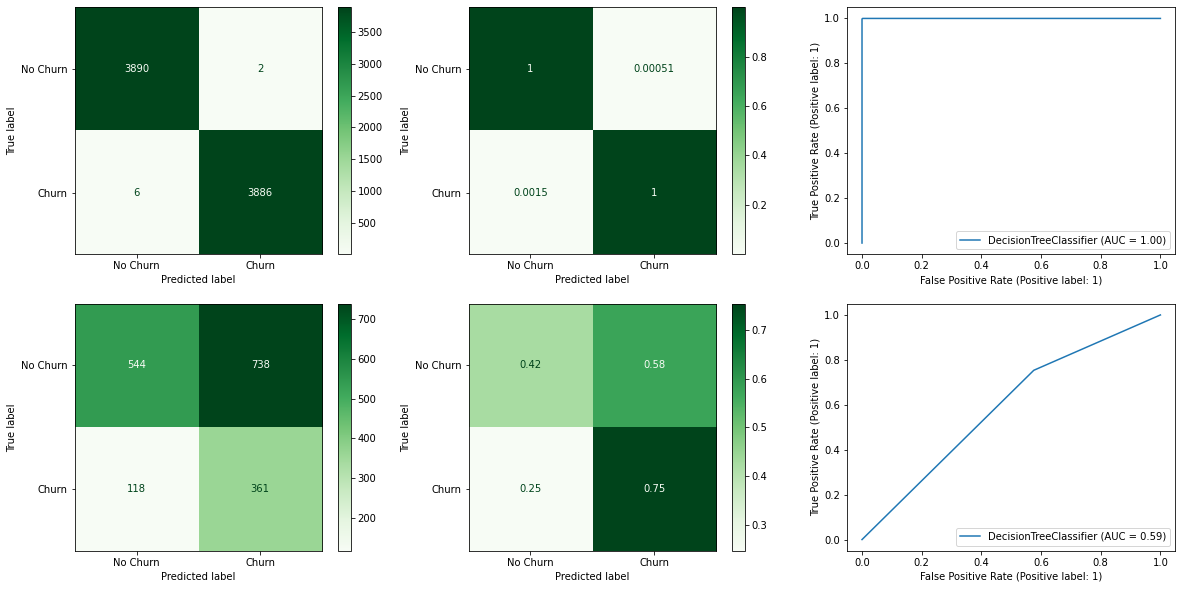

In [81]:
dectree_smote = DecisionTreeClassifier(random_state = 42)
dectree_smote.fit(X_train_smote, y_train_smote) 
tempdf = evaluate_classification(dectree_smote, 'DecTree Smote', X_train_smote, y_train_smote, X_test_transformed, y_test, classes = ['No Churn', 'Churn'])
modelperformance = modelperformance.append(tempdf, ignore_index = True)

> Very poor model with high bias and poor performance on majority class after SMOTE.

## Random Forest

RF Performance on the Training Set
Train accuracy score: 0.998485422188565
              precision    recall  f1-score   support

    No Churn       1.00      1.00      1.00      3892
       Churn       1.00      1.00      1.00      1390

    accuracy                           1.00      5282
   macro avg       1.00      1.00      1.00      5282
weighted avg       1.00      1.00      1.00      5282

RF Performance on the Testing Set
Test accuracy score: 0.7904599659284497
              precision    recall  f1-score   support

    No Churn       0.82      0.91      0.86      1282
       Churn       0.66      0.48      0.55       479

    accuracy                           0.79      1761
   macro avg       0.74      0.69      0.71      1761
weighted avg       0.78      0.79      0.78      1761



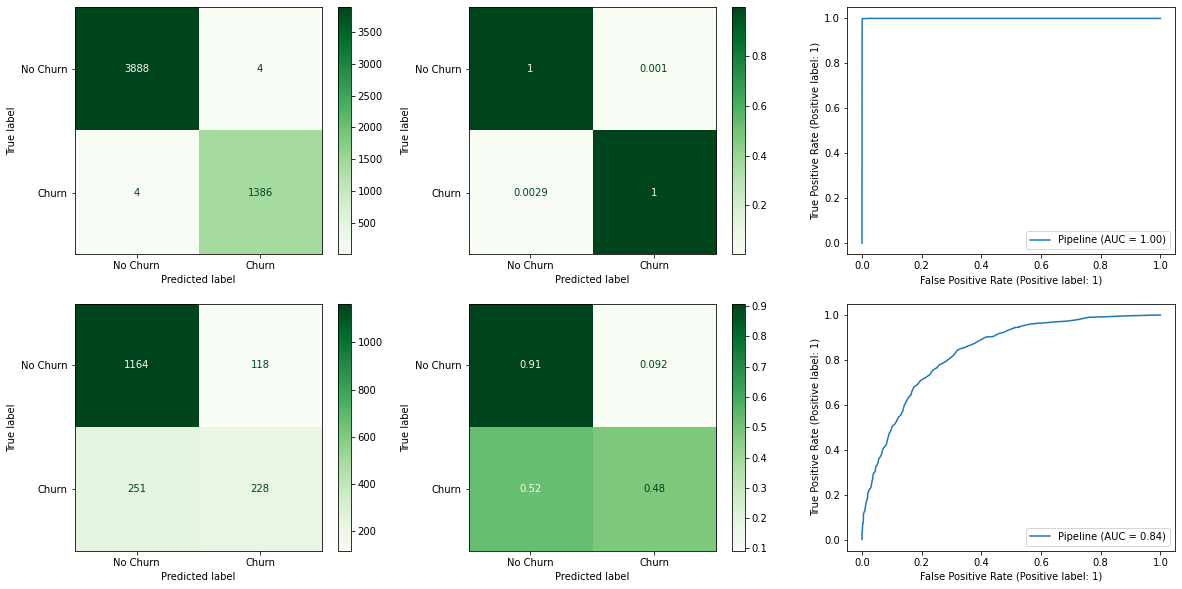

In [82]:
rf = RandomForestClassifier(random_state = 42)
rf_pipe = make_pipeline(col_transformer, rf)
rf_pipe.fit(X_train, y_train)
tempdf = evaluate_classification(rf_pipe, 'RF', X_train, y_train, X_test, y_test, classes = ['No Churn', 'Churn'])
modelperformance = modelperformance.append(tempdf, ignore_index = True)

> High bias.

### Class_Weight = Balanced

RF Class Balanced Performance on the Training Set
Train accuracy score: 0.998485422188565
              precision    recall  f1-score   support

    No Churn       1.00      1.00      1.00      3892
       Churn       0.99      1.00      1.00      1390

    accuracy                           1.00      5282
   macro avg       1.00      1.00      1.00      5282
weighted avg       1.00      1.00      1.00      5282

RF Class Balanced Performance on the Testing Set
Test accuracy score: 0.7950028392958546
              precision    recall  f1-score   support

    No Churn       0.82      0.92      0.87      1282
       Churn       0.68      0.47      0.55       479

    accuracy                           0.80      1761
   macro avg       0.75      0.69      0.71      1761
weighted avg       0.78      0.80      0.78      1761



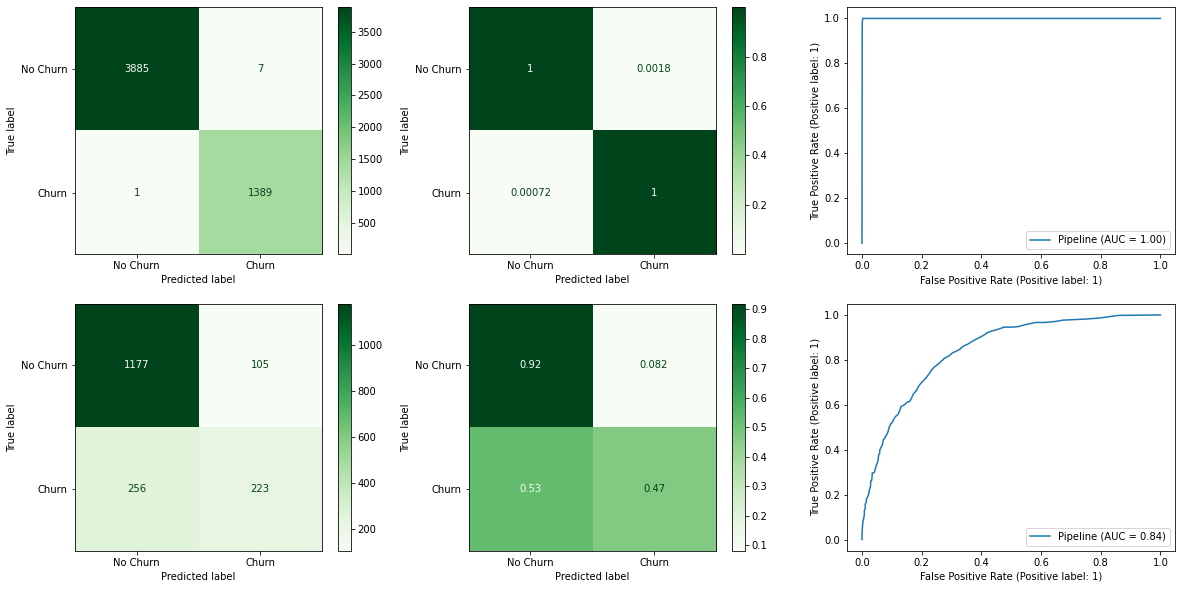

In [83]:
rf = RandomForestClassifier(class_weight='balanced', random_state = 42)
rf_pipe = make_pipeline(col_transformer, rf)
rf_pipe.fit(X_train, y_train)
tempdf = evaluate_classification(rf_pipe, 'RF Class Balanced', X_train, y_train, X_test, y_test, classes = ['No Churn', 'Churn'])
modelperformance = modelperformance.append(tempdf, ignore_index = True)

### SMOTE

Random Forest Smote Performance on the Training Set
Train accuracy score: 0.998972250770812
              precision    recall  f1-score   support

    No Churn       1.00      1.00      1.00      3892
       Churn       1.00      1.00      1.00      3892

    accuracy                           1.00      7784
   macro avg       1.00      1.00      1.00      7784
weighted avg       1.00      1.00      1.00      7784

Random Forest Smote Performance on the Testing Set
Test accuracy score: 0.7637705848949461
              precision    recall  f1-score   support

    No Churn       0.89      0.77      0.83      1282
       Churn       0.55      0.74      0.63       479

    accuracy                           0.76      1761
   macro avg       0.72      0.76      0.73      1761
weighted avg       0.80      0.76      0.77      1761



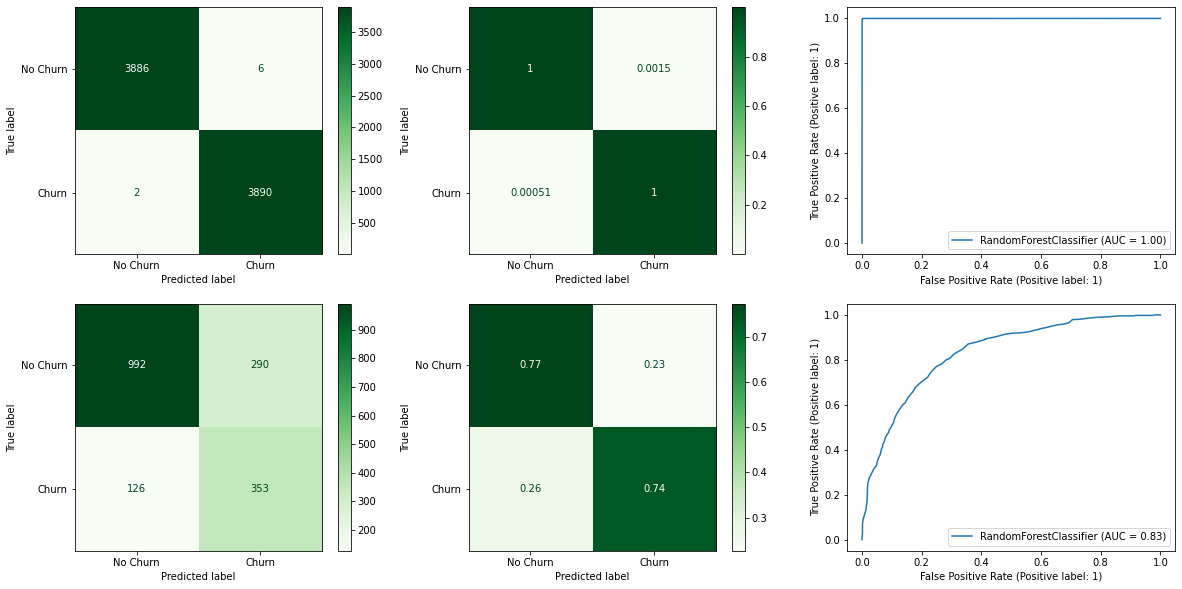

In [84]:
rf_smote = RandomForestClassifier(random_state = 42)
rf_smote.fit(X_train_smote, y_train_smote) 
tempdf = evaluate_classification(rf_smote, 'Random Forest Smote', X_train_smote, y_train_smote, X_test_transformed, y_test, classes = ['No Churn', 'Churn'])
modelperformance = modelperformance.append(tempdf, ignore_index = True)

## Bagging

Bagging Performance on the Training Set
Train accuracy score: 0.9823930329420674
              precision    recall  f1-score   support

    No Churn       0.98      1.00      0.99      3892
       Churn       0.99      0.94      0.97      1390

    accuracy                           0.98      5282
   macro avg       0.98      0.97      0.98      5282
weighted avg       0.98      0.98      0.98      5282

Bagging Performance on the Testing Set
Test accuracy score: 0.768313458262351
              precision    recall  f1-score   support

    No Churn       0.80      0.90      0.85      1282
       Churn       0.61      0.41      0.49       479

    accuracy                           0.77      1761
   macro avg       0.71      0.66      0.67      1761
weighted avg       0.75      0.77      0.75      1761



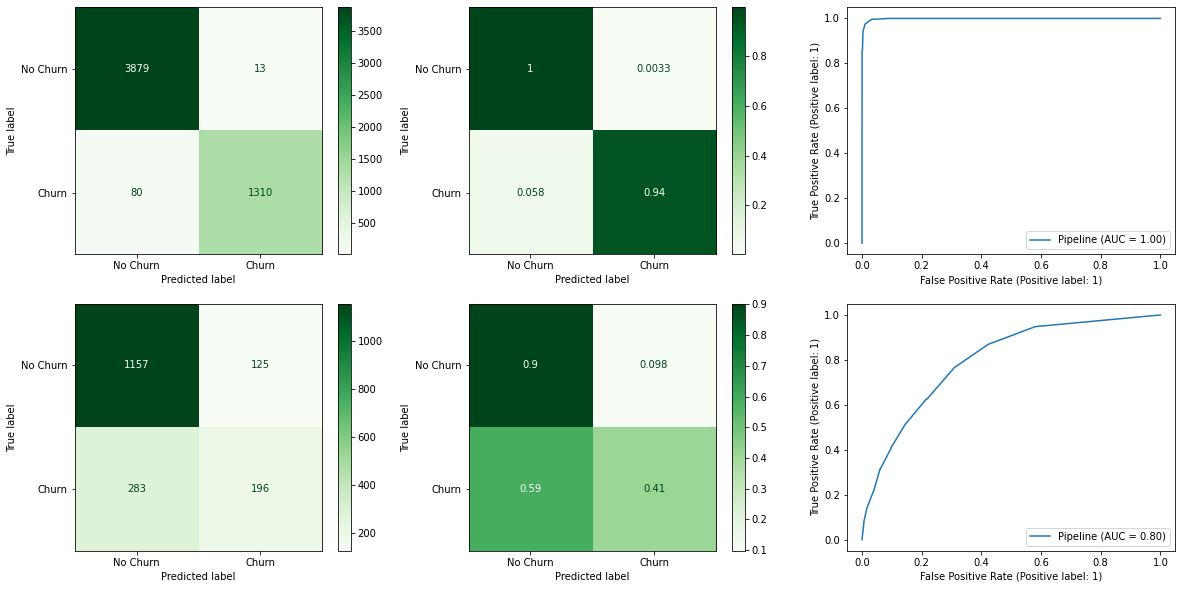

In [85]:
bt = BaggingClassifier(random_state = 42)
bt_pipe = make_pipeline(col_transformer, bt)
bt_pipe.fit(X_train, y_train)
tempdf = evaluate_classification(bt_pipe, 'Bagging', X_train, y_train, X_test, y_test, classes = ['No Churn', 'Churn'])
modelperformance = modelperformance.append(tempdf, ignore_index = True)

> No class_weight parameter for this class exists

### SMOTE

Bagging Smote Performance on the Training Set
Train accuracy score: 0.9893371017471737
              precision    recall  f1-score   support

    No Churn       0.99      0.99      0.99      3892
       Churn       0.99      0.99      0.99      3892

    accuracy                           0.99      7784
   macro avg       0.99      0.99      0.99      7784
weighted avg       0.99      0.99      0.99      7784

Bagging Smote Performance on the Testing Set
Test accuracy score: 0.7467348097671778
              precision    recall  f1-score   support

    No Churn       0.87      0.77      0.81      1282
       Churn       0.53      0.70      0.60       479

    accuracy                           0.75      1761
   macro avg       0.70      0.73      0.71      1761
weighted avg       0.78      0.75      0.76      1761



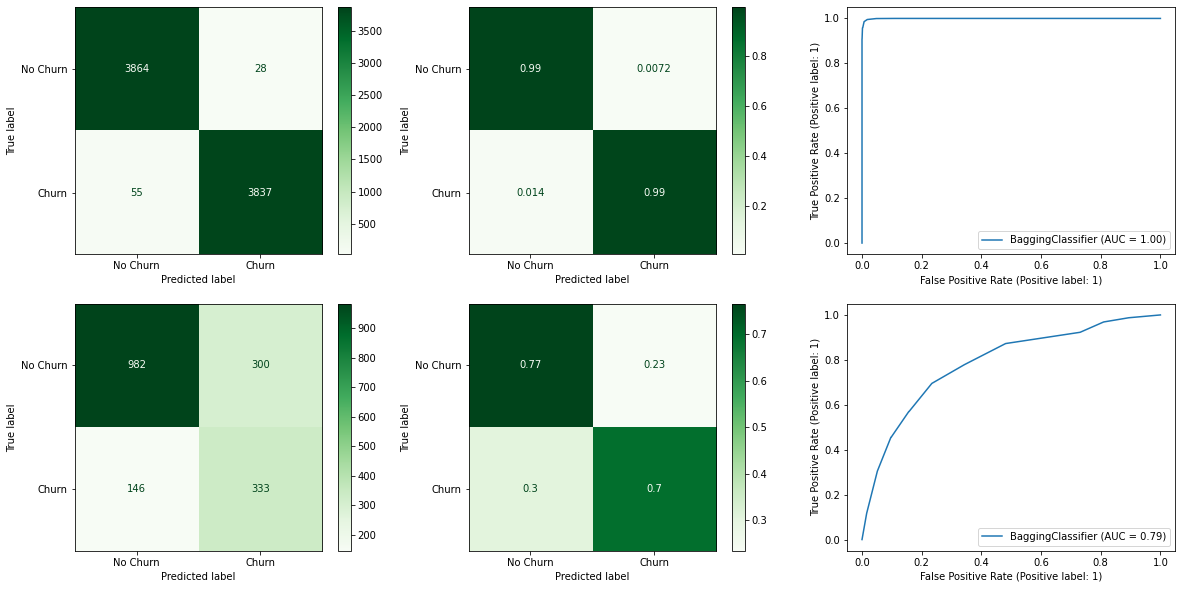

In [86]:
bt_smote = BaggingClassifier(random_state = 42)
bt_smote.fit(X_train_smote, y_train_smote) 
tempdf = evaluate_classification(bt_smote, 'Bagging Smote', X_train_smote, y_train_smote, X_test_transformed, y_test, classes = ['No Churn', 'Churn'])
modelperformance = modelperformance.append(tempdf, ignore_index = True)

## Gradient Boosting

### Gradient Boosting Classifier

GBC Performance on the Training Set
Train accuracy score: 0.8292313517606967
              precision    recall  f1-score   support

    No Churn       0.86      0.92      0.89      3892
       Churn       0.73      0.56      0.63      1390

    accuracy                           0.83      5282
   macro avg       0.79      0.74      0.76      5282
weighted avg       0.82      0.83      0.82      5282

GBC Performance on the Testing Set
Test accuracy score: 0.794434980124929
              precision    recall  f1-score   support

    No Churn       0.83      0.90      0.86      1282
       Churn       0.66      0.50      0.57       479

    accuracy                           0.79      1761
   macro avg       0.74      0.70      0.72      1761
weighted avg       0.78      0.79      0.78      1761



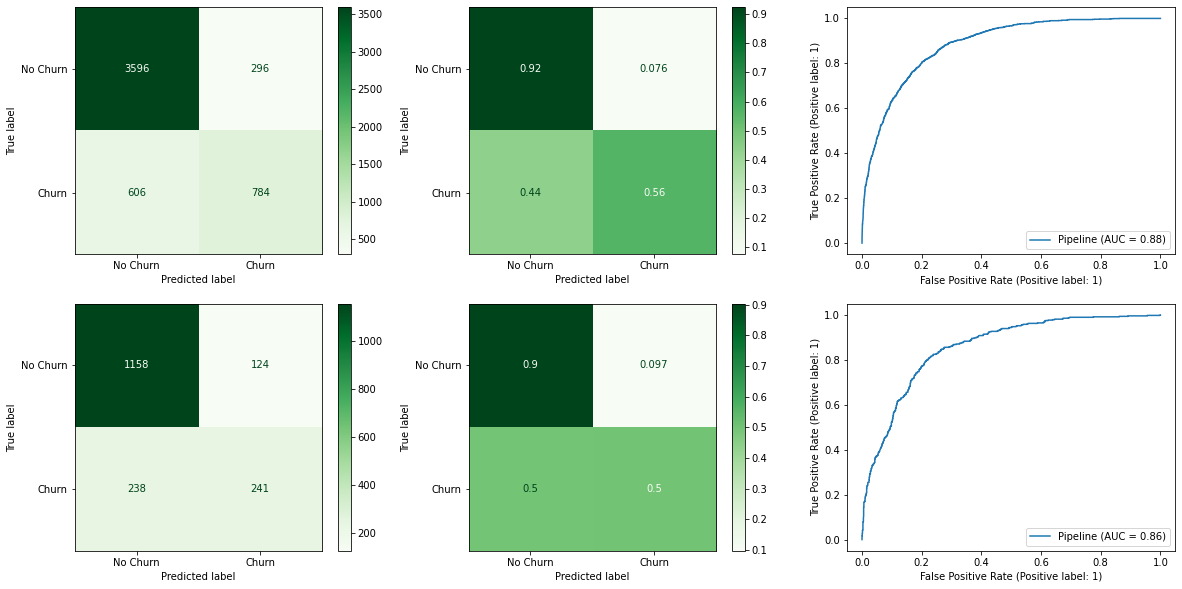

In [87]:
gbc = GradientBoostingClassifier()
gbc_pipe = make_pipeline(col_transformer, gbc)
gbc_pipe.fit(X_train, y_train)
tempdf = evaluate_classification(gbc_pipe, 'GBC', X_train, y_train, X_test, y_test, classes = ['No Churn', 'Churn'])
modelperformance = modelperformance.append(tempdf, ignore_index = True)

> Poor predictions of minority class

> No class_weight parameter exists for this class

#### SMOTE

Gradient Boosting Smote Performance on the Training Set
Train accuracy score: 0.8599691675231244
              precision    recall  f1-score   support

    No Churn       0.88      0.84      0.86      3892
       Churn       0.84      0.88      0.86      3892

    accuracy                           0.86      7784
   macro avg       0.86      0.86      0.86      7784
weighted avg       0.86      0.86      0.86      7784

Gradient Boosting Smote Performance on the Testing Set
Test accuracy score: 0.35036910846110164
              precision    recall  f1-score   support

    No Churn       0.95      0.11      0.20      1282
       Churn       0.29      0.99      0.45       479

    accuracy                           0.35      1761
   macro avg       0.62      0.55      0.33      1761
weighted avg       0.77      0.35      0.27      1761



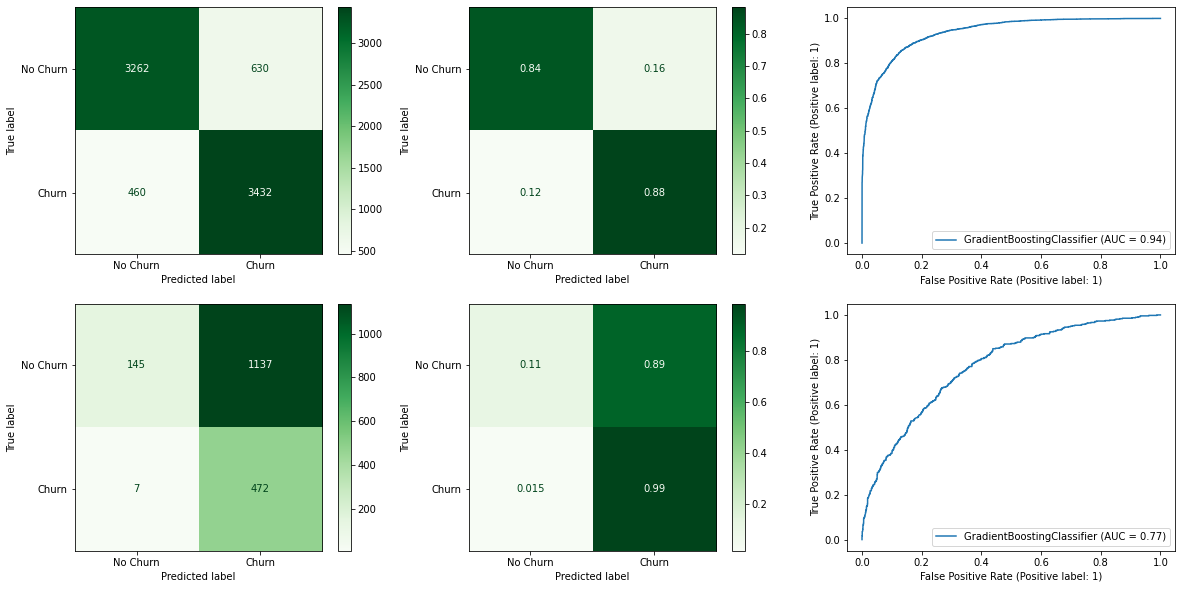

In [88]:
gbc_smote = GradientBoostingClassifier()
gbc_smote.fit(X_train_smote, y_train_smote) 
tempdf = evaluate_classification(gbc_smote, 'Gradient Boosting Smote', X_train_smote, y_train_smote, X_test_transformed, y_test, classes = ['No Churn', 'Churn'])
modelperformance = modelperformance.append(tempdf, ignore_index = True)

### LightGBM

LightGBM Performance on the Training Set
Train accuracy score: 0.8958727754638395
              precision    recall  f1-score   support

    No Churn       0.91      0.95      0.93      3892
       Churn       0.85      0.73      0.79      1390

    accuracy                           0.90      5282
   macro avg       0.88      0.84      0.86      5282
weighted avg       0.89      0.90      0.89      5282

LightGBM Performance on the Testing Set
Test accuracy score: 0.7898921067575241
              precision    recall  f1-score   support

    No Churn       0.83      0.90      0.86      1282
       Churn       0.64      0.51      0.57       479

    accuracy                           0.79      1761
   macro avg       0.74      0.70      0.71      1761
weighted avg       0.78      0.79      0.78      1761



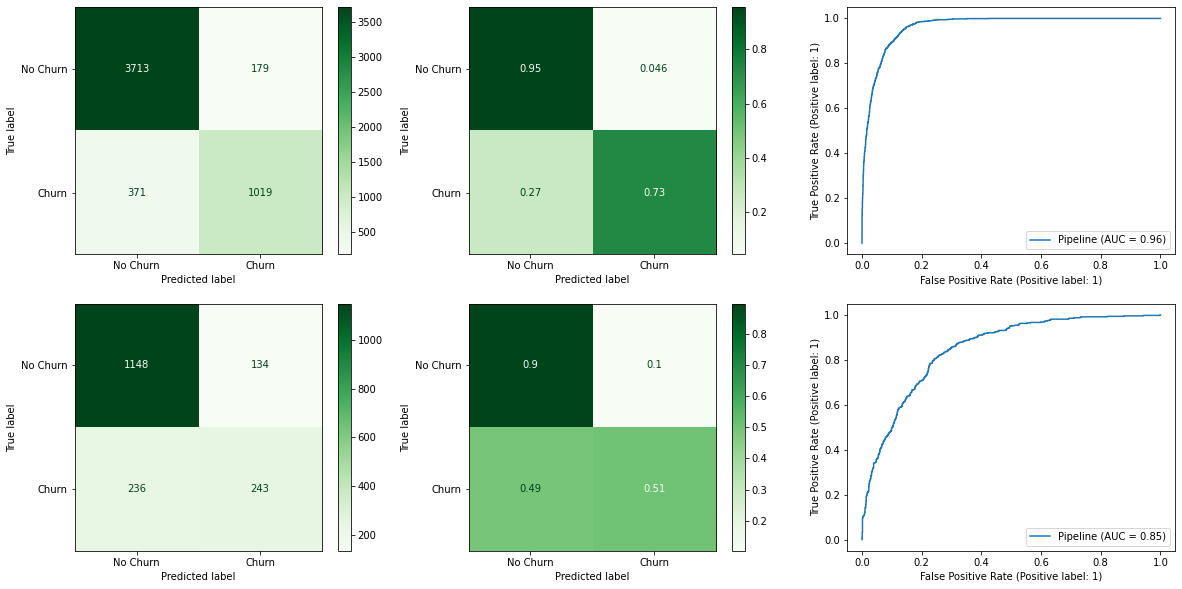

In [89]:
lgbm = LGBMClassifier()
lgbm_pipe = make_pipeline(col_transformer, lgbm)
lgbm_pipe.fit(X_train, y_train)
tempdf = evaluate_classification(lgbm_pipe, 'LightGBM', X_train, y_train, X_test, y_test, classes = ['No Churn', 'Churn'])
modelperformance = modelperformance.append(tempdf, ignore_index = True)

#### Balanced Class Weight

LightGBM Class Balanced Performance on the Training Set
Train accuracy score: 0.8761832639151836
              precision    recall  f1-score   support

    No Churn       0.99      0.84      0.91      3892
       Churn       0.69      0.97      0.81      1390

    accuracy                           0.88      5282
   macro avg       0.84      0.91      0.86      5282
weighted avg       0.91      0.88      0.88      5282

LightGBM Class Balanced Performance on the Testing Set
Test accuracy score: 0.7808063600227144
              precision    recall  f1-score   support

    No Churn       0.90      0.79      0.84      1282
       Churn       0.57      0.75      0.65       479

    accuracy                           0.78      1761
   macro avg       0.73      0.77      0.75      1761
weighted avg       0.81      0.78      0.79      1761



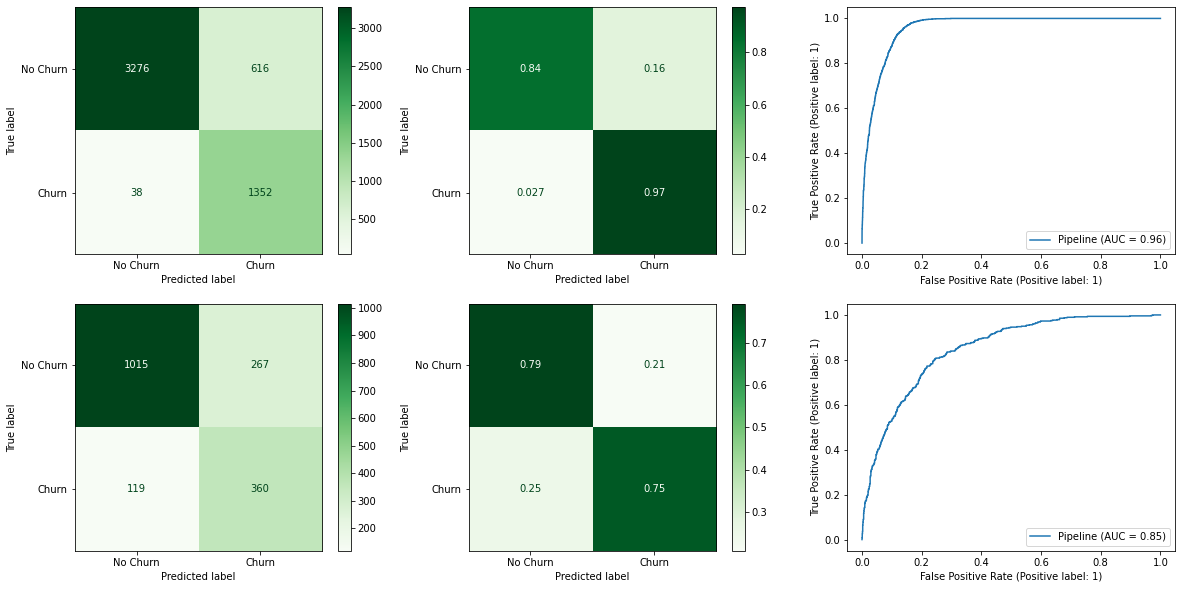

In [90]:
lgbm = LGBMClassifier(class_weight = 'balanced')
lgbm_pipe = make_pipeline(col_transformer, lgbm)
lgbm_pipe.fit(X_train, y_train)
tempdf = evaluate_classification(lgbm_pipe, 'LightGBM Class Balanced', X_train, y_train, X_test, y_test, classes = ['No Churn', 'Churn'])
modelperformance = modelperformance.append(tempdf, ignore_index = True)

> Much better handling for the minority churn class.

#### SMOTE

LGBM Smote Performance on the Training Set
Train accuracy score: 0.9190647482014388
              precision    recall  f1-score   support

    No Churn       0.92      0.92      0.92      3892
       Churn       0.92      0.92      0.92      3892

    accuracy                           0.92      7784
   macro avg       0.92      0.92      0.92      7784
weighted avg       0.92      0.92      0.92      7784

LGBM Smote Performance on the Testing Set
Test accuracy score: 0.3986371379897785
              precision    recall  f1-score   support

    No Churn       0.97      0.18      0.30      1282
       Churn       0.31      0.99      0.47       479

    accuracy                           0.40      1761
   macro avg       0.64      0.58      0.39      1761
weighted avg       0.79      0.40      0.35      1761



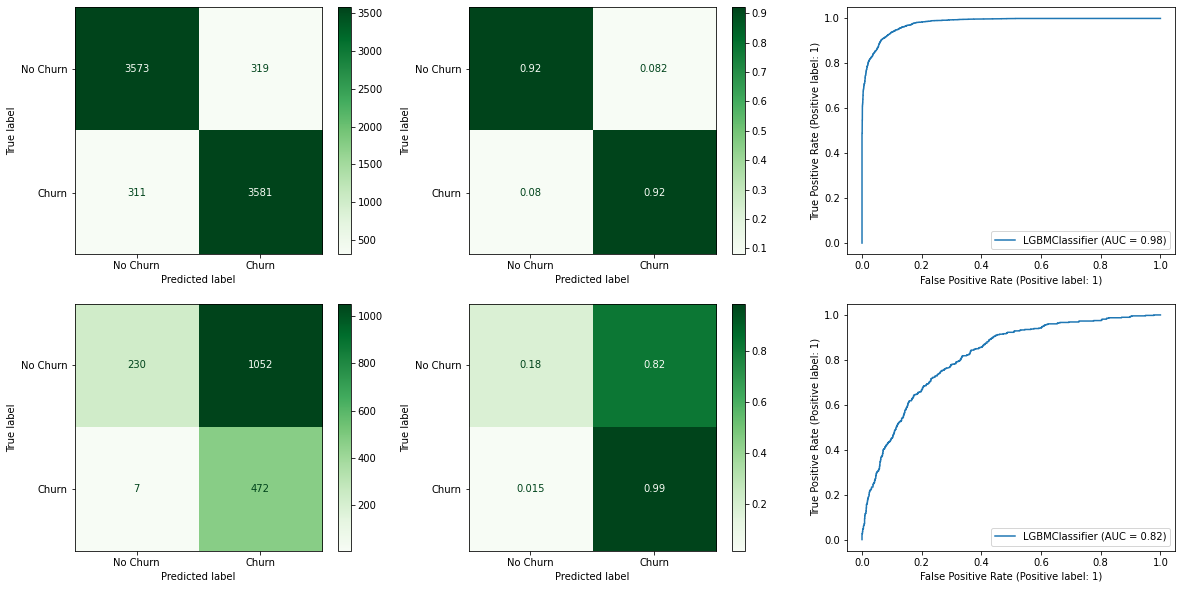

In [91]:
lgbm_smote = LGBMClassifier()
lgbm_smote.fit(X_train_smote, y_train_smote) 
tempdf = evaluate_classification(lgbm_smote, 'LGBM Smote', X_train_smote, y_train_smote, X_test_transformed, y_test, classes = ['No Churn', 'Churn'])
modelperformance = modelperformance.append(tempdf, ignore_index = True)

### XGBoost

XGB Performance on the Training Set
Train accuracy score: 0.8207118515713745
              precision    recall  f1-score   support

    No Churn       0.85      0.92      0.88      3892
       Churn       0.70      0.55      0.62      1390

    accuracy                           0.82      5282
   macro avg       0.78      0.73      0.75      5282
weighted avg       0.81      0.82      0.81      5282

XGB Performance on the Testing Set
Test accuracy score: 0.7984099943214082
              precision    recall  f1-score   support

    No Churn       0.83      0.91      0.87      1282
       Churn       0.67      0.50      0.58       479

    accuracy                           0.80      1761
   macro avg       0.75      0.71      0.72      1761
weighted avg       0.79      0.80      0.79      1761



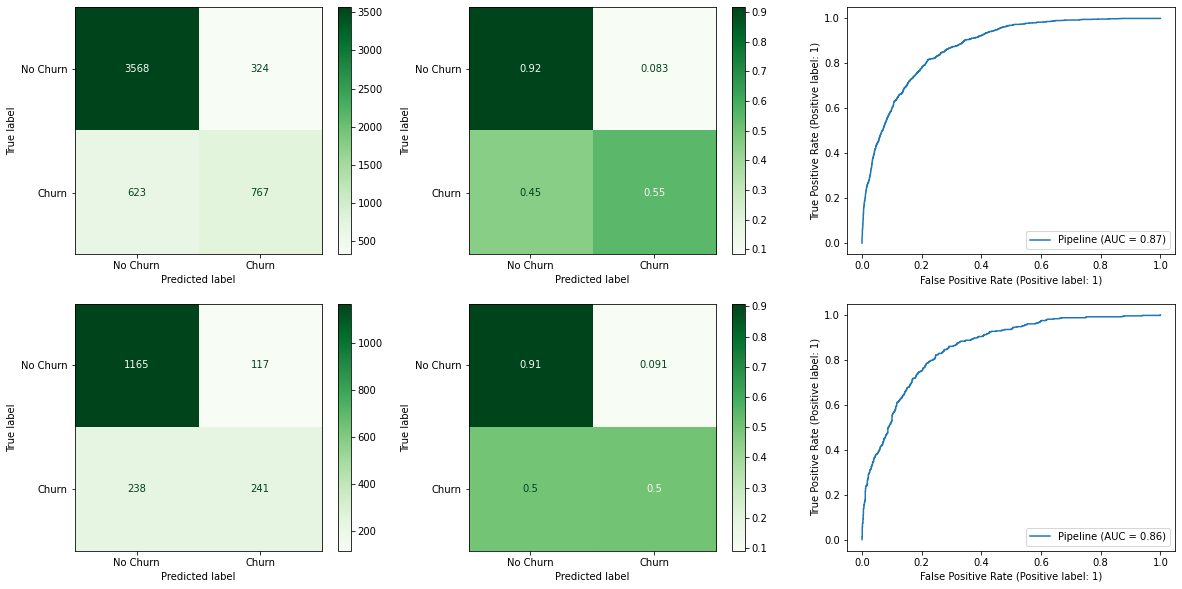

In [92]:
xgb = XGBClassifier()
xgb_pipe = make_pipeline(col_transformer, xgb)
xgb_pipe.fit(X_train, y_train)
tempdf = evaluate_classification(xgb_pipe, 'XGB', X_train, y_train, X_test, y_test, classes = ['No Churn', 'Churn'])
modelperformance = modelperformance.append(tempdf, ignore_index = True)

#### Balanced Class Weight

XGB Class Balanced Performance on the Training Set
Train accuracy score: 0.8207118515713745
              precision    recall  f1-score   support

    No Churn       0.85      0.92      0.88      3892
       Churn       0.70      0.55      0.62      1390

    accuracy                           0.82      5282
   macro avg       0.78      0.73      0.75      5282
weighted avg       0.81      0.82      0.81      5282

XGB Class Balanced Performance on the Testing Set
Test accuracy score: 0.7984099943214082
              precision    recall  f1-score   support

    No Churn       0.83      0.91      0.87      1282
       Churn       0.67      0.50      0.58       479

    accuracy                           0.80      1761
   macro avg       0.75      0.71      0.72      1761
weighted avg       0.79      0.80      0.79      1761



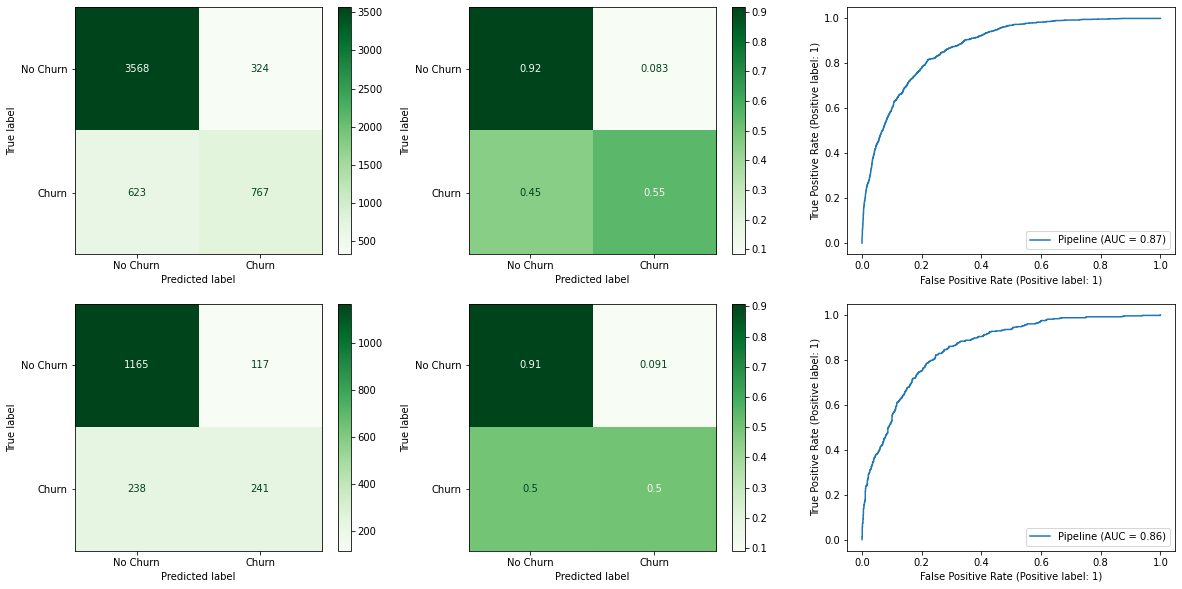

In [93]:
xgb = XGBClassifier(class_weight = 'balanced')
xgb_pipe = make_pipeline(col_transformer, xgb)
xgb_pipe.fit(X_train, y_train)
tempdf = evaluate_classification(xgb_pipe, 'XGB Class Balanced', X_train, y_train, X_test, y_test, classes = ['No Churn', 'Churn'])
modelperformance = modelperformance.append(tempdf, ignore_index = True)

> No benefit for minority class with use of XGBoost class_weight parameter

#### SMOTE

LGBM Smote Performance on the Training Set
Train accuracy score: 0.8566289825282631
              precision    recall  f1-score   support

    No Churn       0.87      0.83      0.85      3892
       Churn       0.84      0.88      0.86      3892

    accuracy                           0.86      7784
   macro avg       0.86      0.86      0.86      7784
weighted avg       0.86      0.86      0.86      7784

LGBM Smote Performance on the Testing Set
Test accuracy score: 0.34014764338444065
              precision    recall  f1-score   support

    No Churn       0.95      0.10      0.18      1282
       Churn       0.29      0.99      0.45       479

    accuracy                           0.34      1761
   macro avg       0.62      0.54      0.31      1761
weighted avg       0.77      0.34      0.25      1761



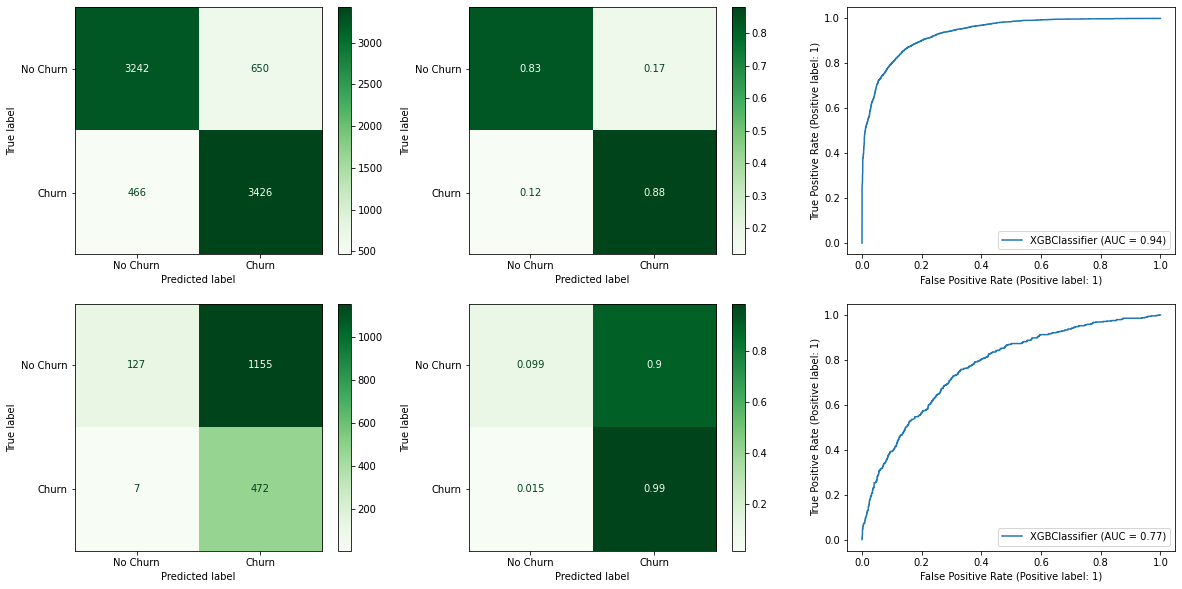

In [94]:
xgb_smote = XGBClassifier() 
xgb_smote.fit(X_train_smote, y_train_smote) 
tempdf = evaluate_classification(xgb_smote, 'LGBM Smote', X_train_smote, y_train_smote, X_test_transformed, y_test, classes = ['No Churn', 'Churn'])
modelperformance = modelperformance.append(tempdf, ignore_index = True)

# Choice of Production Model

In [95]:
# Summary of all models
modelperformance

,model name,accuracy,roc_auc,precision_min,recall_min,f1-score_min,precision_maj,recall_maj,f1-score_maj
0,KNN,0.763203,0.787949,0.568282,0.538622,0.553055,0.830910,0.847114,0.838934
1,KNN Smote,0.694492,0.766667,0.461738,0.743215,0.569600,0.875758,0.676287,0.763204
2,LogReg,0.812606,0.860225,0.683047,0.580376,0.627540,0.851551,0.899376,0.874810
3,LogReg Class Balanced,0.755253,0.859642,0.532000,0.832985,0.649308,0.920870,0.726209,0.812037
4,LogReg Smote,0.756956,0.858910,0.534789,0.818372,0.646865,0.915370,0.734009,0.814719
5,DecTree,0.743328,0.663804,0.530612,0.488518,0.508696,0.814394,0.838534,0.826287
6,DecTree Class Balanced,0.740488,0.664136,0.524336,0.494781,0.509130,0.815126,0.832293,0.823620
7,DecTree Smote,0.513913,0.588995,0.328480,0.753653,0.457541,0.821752,0.424337,0.559671
8,RF,0.790460,0.835788,0.658960,0.475992,0.552727,0.822615,0.907956,0.863181
9,RF Class Balanced,0.795003,0.841564,0.679878,0.465553,0.552664,0.821354,0.918097,0.867035


In [120]:
# narrow down the models
# > 75% accuracy
# > 53% precision on the minority class
# > 53% recall on the minority class
# > 60% f1-score on the minority class
models = modelperformance.loc[(modelperformance['accuracy']>0.75) & (modelperformance['precision_min'] > 0.53) & (modelperformance['recall_min'] > 0.53) & (modelperformance['f1-score_min'] > 0.60)]
models

,model name,accuracy,roc_auc,precision_min,recall_min,f1-score_min,precision_maj,recall_maj,f1-score_maj
2,LogReg,0.812606,0.860225,0.683047,0.580376,0.627540,0.851551,0.899376,0.874810
3,LogReg Class Balanced,0.755253,0.859642,0.532000,0.832985,0.649308,0.920870,0.726209,0.812037
4,LogReg Smote,0.756956,0.858910,0.534789,0.818372,0.646865,0.915370,0.734009,0.814719
10,Random Forest Smote,0.763771,0.833090,0.548989,0.736952,0.629234,0.887299,0.773791,0.826667
16,LightGBM Class Balanced,0.780806,0.849174,0.574163,0.751566,0.650995,0.895062,0.791732,0.840232


To further select a model, I will explore what is more important to maximize, recall or precision:
- Precision: Out of all the customers predicted to churn, how many customers will actually churn?
- Recall: Out of all the churned customers, how many does the model successfuly predict?

To optimize one or the other is a business choice and dependent on the circumstances to which you are applying this model. I could foresee either being of importance when deciding which customers to reach out to. If you want to be sure you are reaching out to only the customers who are likely to churn (and not others who are not in danger of churning), you would want to maximize precision. If you are trying to reach out to all customers in danger of churning (and it doesn't matter whether you reach some who are not likely to churn), recall would be most important.

When trying to determine what things cause a person to churn (and promotions of which upgrades would creat the greatest returns), it may be better to select recall to optimize, as a model with high recall will have more ability to select all customers who will churn. In this case, a Type I error (making a false prediction that someone will churn) is of less significance than a Type II error (making a false prediction that someone will stay). We are trying to capture all the customers who whill churn.

This would be something I would propose to stakeholders to determine the best model.



For purposes of this project and my goal of understanding the customers who churn, I will select a model with high recall. The model with highest recall was the **Logistic Regression Class Balanced**.

I will attempt to tune the hyperparameters to get a bit better performance:

## Hyperparameter Tuning

Critical tunable parameters in Logistic Regression 
- Penalty: l1 or l2 
- C (penalty strength)

LogReg Class Balanced Performance on the Training Set
Train accuracy score: 0.7385460053010223
              precision    recall  f1-score   support

    No Churn       0.91      0.72      0.80      3892
       Churn       0.50      0.80      0.62      1390

    accuracy                           0.74      5282
   macro avg       0.71      0.76      0.71      5282
weighted avg       0.80      0.74      0.75      5282

LogReg Class Balanced Performance on the Testing Set
Test accuracy score: 0.7552526973310619
              precision    recall  f1-score   support

    No Churn       0.92      0.73      0.81      1282
       Churn       0.53      0.83      0.65       479

    accuracy                           0.76      1761
   macro avg       0.73      0.78      0.73      1761
weighted avg       0.82      0.76      0.77      1761



,model name,accuracy,roc_auc,precision_min,recall_min,f1-score_min,precision_maj,recall_maj,f1-score_maj
0,LogReg Class Balanced,0.755253,0.859655,0.532,0.832985,0.649308,0.92087,0.726209,0.812037


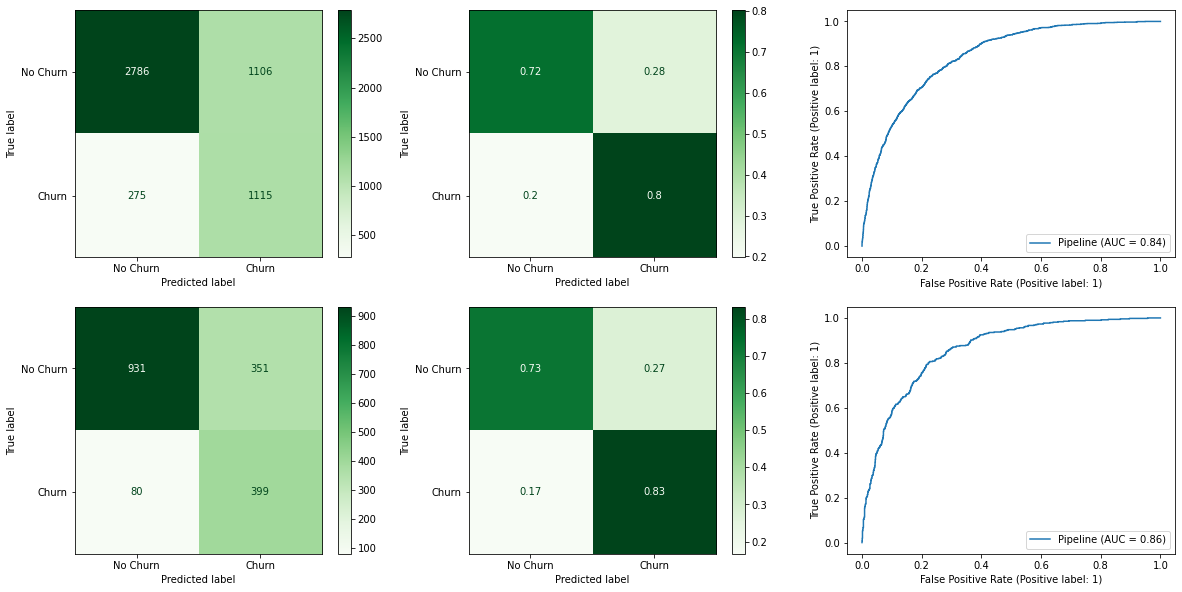

In [126]:
logreg_balanced = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')
logreg_balanced_pipe = make_pipeline(col_transformer, logreg_balanced)
logreg_balanced_pipe.fit(X_train, y_train)
evaluate_classification(logreg_balanced_pipe, 'LogReg Class Balanced', X_train, y_train, X_test, y_test, classes = ['No Churn', 'Churn'])

In [127]:
logreg_balanced_pipe.get_params()

{'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('pipeline-1',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('onehotencoder',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse=False)),
                                                  ('standardscaler',
                                                   StandardScaler())]),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fcb85db1510>),
                                 ('pipeline-2',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer(strategy='median')),
                        

In [128]:
params = {'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
          'logisticregression__penalty': ['l1', 'l2']}

logistic_grid = GridSearchCV(logreg_balanced_pipe, params)
logistic_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False)),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.m...
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fcb838206d0>)])),
                                       ('logisticregression',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           solver='liblinear'))]),
             param_grid={'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1,
                                                   10, 100, 1000],
                         'logisticregression__penalty': ['l1', 'l2']})

In [129]:
logistic_grid.best_params_
# these were the default values

{'logisticregression__C': 1, 'logisticregression__penalty': 'l2'}

In [130]:
best_logreg = logistic_grid.best_estimator_

Production Model Performance on the Training Set
Train accuracy score: 0.7385460053010223
              precision    recall  f1-score   support

    No Churn       0.91      0.72      0.80      3892
       Churn       0.50      0.80      0.62      1390

    accuracy                           0.74      5282
   macro avg       0.71      0.76      0.71      5282
weighted avg       0.80      0.74      0.75      5282

Production Model Performance on the Testing Set
Test accuracy score: 0.7552526973310619
              precision    recall  f1-score   support

    No Churn       0.92      0.73      0.81      1282
       Churn       0.53      0.83      0.65       479

    accuracy                           0.76      1761
   macro avg       0.73      0.78      0.73      1761
weighted avg       0.82      0.76      0.77      1761



,model name,accuracy,roc_auc,precision_min,recall_min,f1-score_min,precision_maj,recall_maj,f1-score_maj
0,Production Model,0.755253,0.859655,0.532,0.832985,0.649308,0.92087,0.726209,0.812037


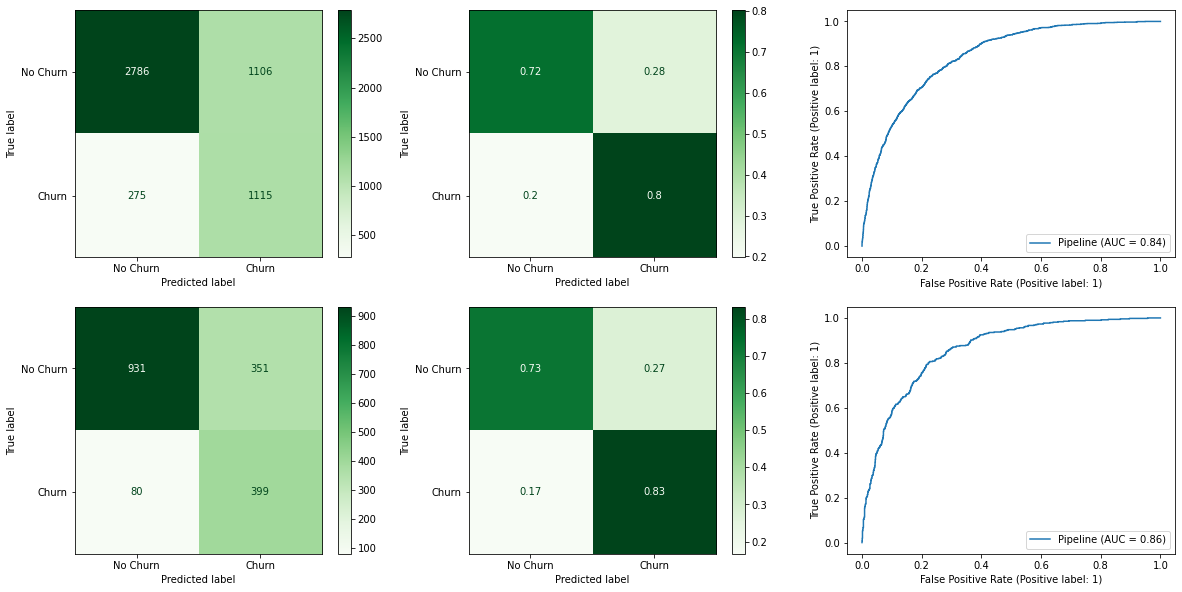

In [131]:
evaluate_classification(best_logreg, 'Production Model', X_train, y_train, X_test, y_test, classes = ['No Churn', 'Churn'])

> In this case, there was no extra benefit gleaned from hypertuning, but at least we know that the parameters are optimized.

To-Do for further exploration:
- [ ]  Use K-means clustering to understand the different groups of customers. See if this can improve our supervised model performance